In [19]:
import pandas as pd 
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

import itertools
#from pmdarima import auto_arima

#statsmodels

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

%matplotlib inline

In [45]:
crude_oil = pd.read_csv("data/crude_oil.csv")
gold = pd.read_csv("data/gold.csv")
dow_jones = pd.read_csv("data/dow_jones.csv")
fed_funds = pd.read_csv("data/fed_funds.csv")

crude_oil['Crude Oil'] = crude_oil['real']
crude_oil = crude_oil.drop(['real', 'nominal'], axis = 1)
crude_oil['date'] = pd.to_datetime(crude_oil['date'])
crude_oil.set_index('date', inplace = True)


gold['Gold'] = gold['real']
gold = gold.drop(['real', 'nominal'], axis = 1)
gold['date'] = pd.to_datetime(gold['date'])
gold.set_index('date', inplace = True)

dow_jones['Dow Jones'] = dow_jones['real']
dow_jones = dow_jones.drop(['real', 'nominal'], axis = 1)
dow_jones['date'] = pd.to_datetime(dow_jones['date'])
dow_jones.set_index('date', inplace = True)

fed_funds['date'] = fed_funds['DATE']
fed_funds['Fed Funds'] = fed_funds['FEDFUNDS']
fed_funds = fed_funds.drop(['DATE', 'FEDFUNDS'], axis = 1)
fed_funds['date'] = pd.to_datetime(fed_funds['date'])
fed_funds.set_index('date', inplace = True)

fed_funds

,Fed Funds
date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
...,...
2022-01-01,0.08
2022-02-01,0.08
2022-03-01,0.20


,Dow Jones,Gold,Crude Oil,Fed Funds
date,,,,
1915-01-01,1636.27,557.10,NaN,NaN
1915-02-01,1608.23,562.68,NaN,NaN
1915-03-01,1796.01,568.36,NaN,NaN
1915-04-01,2098.13,562.68,NaN,NaN
1915-05-01,1881.39,557.10,NaN,NaN
...,...,...,...,...
2022-02-01,34909.38,1957.72,98.59,0.08
2022-03-01,35267.88,1986.24,101.98,0.20
2022-04-01,33339.96,1932.73,105.84,0.33


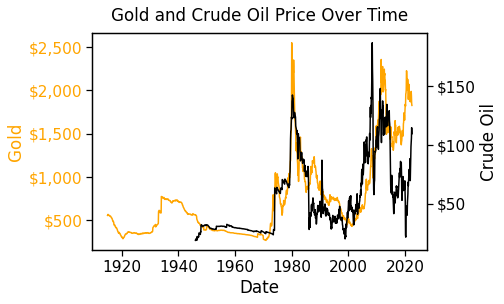

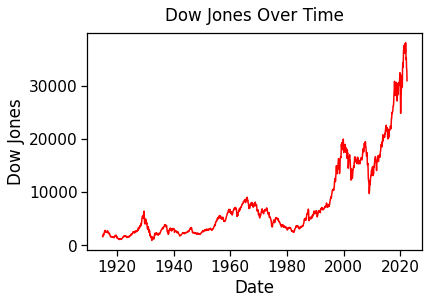

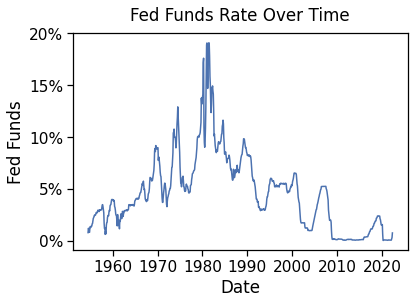

In [40]:
all_data = dow_jones.copy()
all_data['Gold'] = gold['Gold']
#all_data = all_data[400:]
#all_data['Crude Oil'] = crude_oil['Crude Oil']

all_data = pd.concat([all_data, crude_oil, fed_funds], axis=1)
#all_data = pd.concat([all_data, fed_funds], axis=1)
#all_data['Fed Funds'] = fed_funds['Fed Funds']


#all_data.set_index('date', inplace = True)


fig, ax1 = plt.subplots()
ax1.set_title('Gold and Crude Oil Price Over Time', pad = 12) 
color = 'orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold', color = color)
ax1.plot(all_data.index, all_data['Gold'], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(all_data.index, all_data['Crude Oil'], color = color)
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))


fig, ax3 = plt.subplots()
ax3.set_title('Dow Jones Over Time', pad = 12)
ax3.set_xlabel('Date')
color = 'red'
ax3.set_ylabel('Dow Jones')
ax3.plot(all_data.index, all_data['Dow Jones'], color = color)


fig, ax4 = plt.subplots()
ax4.set_title('Fed Funds Rate Over Time', pad = 12)
ax4.set_xlabel('Date')
ax4.set_ylabel('Fed Funds')
ax4.plot(all_data.index, all_data['Fed Funds'])
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}%'))

all_data



C:\Users\wjsdn\AppData\Local\Temp\ipykernel_15408\2911810606.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))


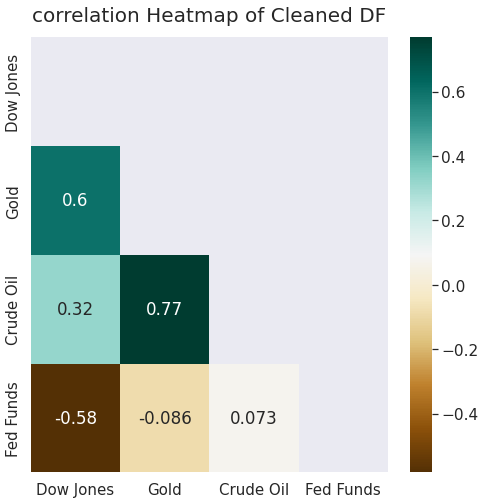

In [27]:
with sns.axes_style('darkgrid'):
    
    f, ax = plt.subplots(figsize=(8,8))
    
    mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))
    
    plt.xticks(fontsize = 15)
    
    plt.yticks(fontsize = 15)
    
    sns.set(font_scale=1.4)
    
    heatmap = sns.heatmap(all_data.corr(), annot = True, mask = mask, cmap = "BrBG")
    
    heatmap.set_title("correlation Heatmap of Cleaned DF", fontdict={'fontsize': 20}, pad =16)

In [70]:
train_df = all_data['1954-07-01':'2020-05-01']
test_df = all_data['2020-05-01':'2022-05-01']

train_df

,Dow Jones,Gold,Crude Oil,Fed Funds
date,,,,
1954-07-01,3780.50,383.68,30.64,0.80
1954-08-01,3648.80,383.68,30.64,1.22
1954-09-01,3931.54,385.13,30.76,1.07
1954-10-01,3840.79,385.13,30.76,0.85
1954-11-01,4218.50,385.13,30.76,0.83
...,...,...,...,...
2020-01-01,32014.08,1791.10,58.42,1.55
2020-02-01,28712.58,1837.78,50.58,1.58
2020-03-01,24810.23,1816.46,23.18,0.65


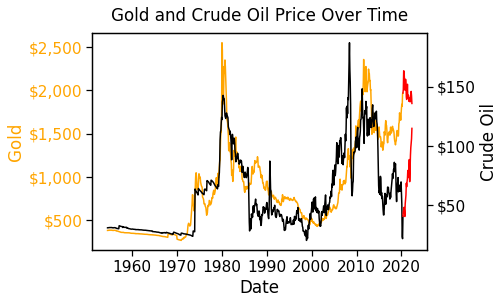

In [71]:
gold = pd.DataFrame()

fig, ax1 = plt.subplots()
ax1.set_title('Gold and Crude Oil Price Over Time', pad = 12) 
color = 'orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold', color = color)
ax1.plot(train_df.index, train_df['Gold'], color = color)
ax1.plot(test_df.index, test_df['Gold'], color = 'red')
ax1.tick_params(axis ='y', labelcolor = color)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(train_df.index, train_df['Crude Oil'], color = color)
ax2.plot(test_df.index, test_df['Crude Oil'], color = 'red')
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [77]:
oil_train = train_df['Crude Oil']


oil_model = ARIMA(oil_train, order = (2,1,2))
oil_model_fit = oil_model.fit()
print(oil_model_fit.summary())

C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              Crude Oil   No. Observations:                  791
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2432.576
Date:                Thu, 30 Jun 2022   AIC                           4875.153
Time:                        17:24:28   BIC                           4898.513
Sample:                    07-01-1954   HQIC                          4884.132
                         - 05-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3706      0.083     16.464      0.000       1.207       1.534
ar.L2         -0.4773      0.089     -5.393      0.000      -0.651      -0.304
ma.L1         -1.1852      0.098    -12.151      0.0

In [79]:
predict = oil_model_fit.predict()
oil_predict = pd.DataFrame(predict)
oil_predict

,predicted_mean
date,
1954-07-01,0.000000
1954-08-01,30.640179
1954-09-01,30.640012
1954-10-01,30.783638
1954-11-01,30.762494
...,...
2020-01-01,70.988494
2020-02-01,56.693005
2020-03-01,48.932688


In [81]:
oil_fore = oil_model_fit.forecast(steps=50)
oil_fore = pd.DataFrame(oil_fore)
oil_fore

,predicted_mean
2020-06-01,45.587673
2020-07-01,48.712450
2020-08-01,50.547882
2020-09-01,51.572097
2020-10-01,52.099847
2020-11-01,52.334330
2020-12-01,52.403818
2021-01-01,52.387139
2021-02-01,52.331110
2021-03-01,52.262275


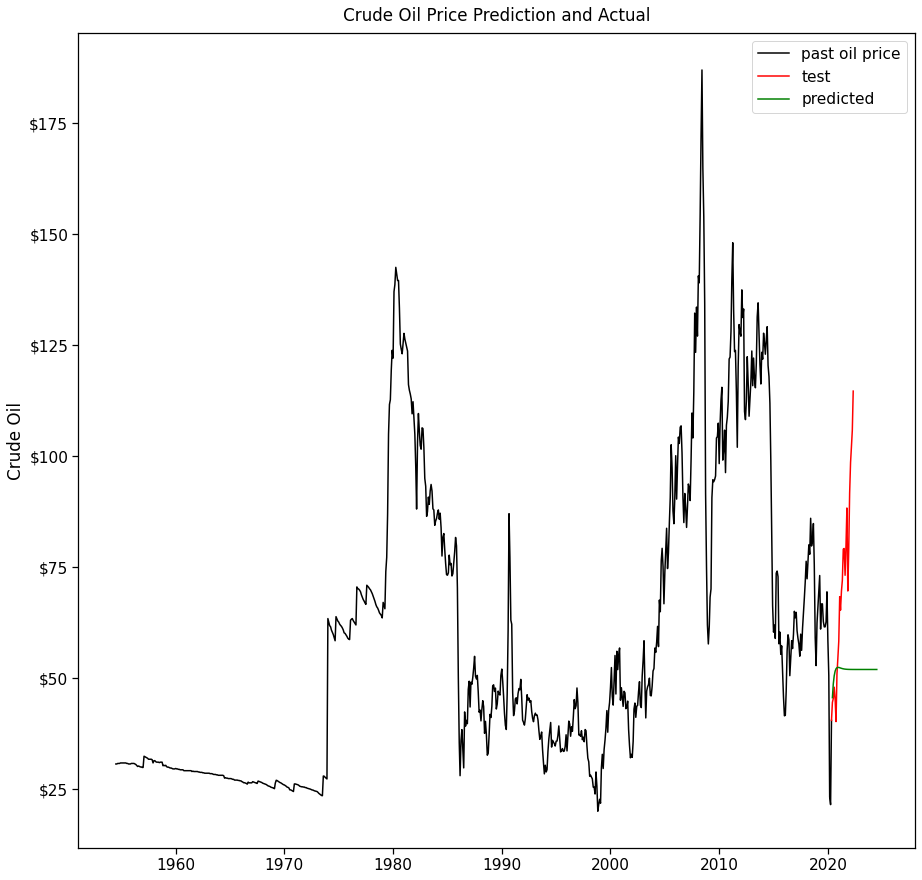

In [91]:
fig, ax2 = plt.subplots(figsize=(15, 15))

ax2.set_title('Crude Oil Price Prediction and Actual', pad = 12) 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(train_df.index, train_df['Crude Oil'], color = color)
ax2.plot(test_df.index, test_df['Crude Oil'], color = 'red')
ax2.plot(oil_fore.index, oil_fore['predicted_mean'], color = 'green')
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.legend(['past oil price', 'test', 'predicted']);